In [1]:
from os.path import join, exists
from os import makedirs
from itertools import product
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from collections import Counter

from brainpipe.system import study
from utils import subjects,score_odor_su
from scipy.stats import ttest_ind, ttest_1samp, pearsonr, spearmanr, zscore
from mne.stats import fdr_correction, bonferroni_correction

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [14]:
"""
Create TPSim DIFF (Wth-Btw) >> Odor, MemRichness, Context
"""
###############################################################################
st = study('Olfacto')
path_wth = join(st.path, 'feature_new/TPSim_by_{}_wth/')
path_btw = join(st.path, 'feature_new/TPSim_by_{}_btw/')
tps_file = '{}_odors=all_tps={}_elecs=psd_freq={}_xpow_{}.npz'
path_diff = join(st.path, 'feature_new/TPSim_by_{}_diff/')
###############################################################################
conds = ['context'] #'context','mem2','mem3','odor'
freqs = ['l_theta','h_theta']
dims = ['E','L']

for dim in dims:
    for su,cond,freq in product(subjects,conds,freqs):
        print('>> processing',su,cond,freq,dim)
        mat_wth = np.load(join(path_wth.format(cond),
                               tps_file.format(su,'wth',freq,dim)),allow_pickle=True)
        mat_btw = np.load(join(path_btw.format(cond),
                               tps_file.format(su,'btw',freq,dim)),allow_pickle=True)
        tps_wth = mat_wth['tps']
        tps_btw = mat_btw['tps']

        #compute diff by item (when only 2 items all combs together)
        items = np.unique(mat_wth[cond])
        combs = mat_btw[cond]
        diff_tps = []
        for item in items:
            wth_item = tps_wth[:,np.where(mat_wth[cond]==item)[0]]
            btw_item = tps_btw[:,[i for i,tr in enumerate(mat_btw[cond]) if item in tr]]
            diff = wth_item - np.mean(btw_item,axis=-1)[:,np.newaxis]
            diff_tps.append(diff)
        #concat along trials dimensions
        diff_tps = np.concatenate(diff_tps,axis=-1)

        dict_save = {}
        for file in mat_wth.files:
            dict_save[file] = mat_wth[file] if file != 'tps' else diff_tps
        if not exists(path_diff.format(cond)):
            makedirs(path_diff.format(cond))
        np.savez(join(path_diff.format(cond),tps_file.format(su,'diff',freq,dim)),**dict_save)

-> Olfacto loaded
>> processing CHAF context l_theta E
>> processing CHAF context h_theta E
>> processing LEFC context l_theta E
>> processing LEFC context h_theta E
>> processing FERJ context l_theta E
>> processing FERJ context h_theta E
>> processing SEMC context l_theta E
>> processing SEMC context h_theta E
>> processing VACJ context l_theta E
>> processing VACJ context h_theta E
>> processing PIRJ context l_theta E
>> processing PIRJ context h_theta E
>> processing CHAF context l_theta L
>> processing CHAF context h_theta L
>> processing LEFC context l_theta L
>> processing LEFC context h_theta L
>> processing FERJ context l_theta L
>> processing FERJ context h_theta L
>> processing SEMC context l_theta L
>> processing SEMC context h_theta L
>> processing VACJ context l_theta L
>> processing VACJ context h_theta L
>> processing PIRJ context l_theta L
>> processing PIRJ context h_theta L


In [16]:
"""
Compute WTH BTW DIFF significance by cond (Odor, Context, MemRichness)
Sum up all results into one csv file
"""
###############################################################################
st = study('Olfacto')
path_wth = join(st.path, 'feature_new/TPSim_by_{}_wth/')
path_btw = join(st.path, 'feature_new/TPSim_by_{}_btw/')
path_diff = join(st.path, 'feature_new/TPSim_by_{}_diff/')
path_save = join(st.path, 'feature_new/Ttest_{}_tps/')
tps_file = '{}_odors=all_tps={}_elecs=psd_freq={}_xpow_E.npz'
csv_file = 'df_wth_btw_diff_freq={}_E.csv'
###############################################################################
conds = ['context'] #'context','mem2','mem3','odor'
freqs = ['l_theta','h_theta']

for freq,cond in product(freqs,conds):
    subjects_c, elecs_c, labels_c = np.array([]), np.array([]), np.array([])
    channels_c, x_c, y_c, z_c = np.array([]), np.array([]), np.array([]), np.array([])
    tps0_c, tps1_c, tps2_c = np.array([]), np.array([]), np.array([])
    T_vals_c_wth, T_vals_c_btw, T_vals_c_diff = np.array([]), np.array([]), np.array([])
    p_vals_c_wth, p_fdr_c_wth, p_bf_c_wth = np.array([]), np.array([]), np.array([])
    p_vals_c_btw, p_fdr_c_btw, p_bf_c_btw = np.array([]), np.array([]), np.array([])
    p_vals_c_diff, p_fdr_c_diff, p_bf_c_diff = np.array([]), np.array([]), np.array([])
    
    for su in subjects:
        mat_wth = np.load(join(path_wth.format(cond),
                           tps_file.format(su,'wth',freq)),allow_pickle=True)
        #select electrodes
        labels, channels = mat_wth['labels'], mat_wth['channels']
        x, y, z = mat_wth['xyz'][:,0], mat_wth['xyz'][:,1], mat_wth['xyz'][:,2]
            
        #load all tps files
        wth_tps = mat_wth['tps']
        nelecs = wth_tps.shape[0]
        btw_tps = np.load(join(path_btw.format(cond),
                               tps_file.format(su,'btw',freq)))['tps']
        diff_tps = np.load(join(path_diff.format(cond),
                               tps_file.format(su,'diff',freq)))['tps']
        #print(su,freq,'wth',wth_tps.shape,'btw',btw_tps.shape,'diff',diff_tps.shape)
        
        #compute stats for all similarities compared to 0
        Tvals_wth, unc_p_wth = ttest_1samp(wth_tps, 0.0, axis=-1)
        Tvals_btw, unc_p_btw = ttest_1samp(btw_tps, 0.0, axis=-1)
        Tvals_diff, unc_p_diff = ttest_1samp(diff_tps, 0.0, axis=-1)
        
        #as it is a one sided one sample t-test (only interested in positive values)
        unc_p_wth, unc_p_btw, unc_p_diff = unc_p_wth/2, unc_p_btw/2, unc_p_diff/2
        _, p_fdr_wth = fdr_correction(unc_p_wth)
        _, p_fdr_btw = fdr_correction(unc_p_btw)
        _, p_fdr_diff = fdr_correction(unc_p_diff)
        _, p_bf_wth = bonferroni_correction(unc_p_wth)
        _, p_bf_btw = bonferroni_correction(unc_p_btw)
        _, p_bf_diff = bonferroni_correction(unc_p_diff)

        #Fill the csv file with elec infos and stats
        subjects_c = np.hstack((subjects_c,np.array([su]*nelecs))) if np.size(subjects_c) else np.array([su]*nelecs)
        elecs_c = np.hstack((elecs_c,np.arange(nelecs))) if np.size(elecs_c) else np.arange(nelecs)
        labels_c = np.hstack((labels_c,labels)) if np.size(labels_c) else labels
        channels_c = np.hstack((channels_c,channels)) if np.size(channels_c) else channels
        x_c = np.hstack((x_c,x)) if np.size(x_c) else x
        y_c = np.hstack((y_c,y)) if np.size(y_c) else y
        z_c = np.hstack((z_c,z)) if np.size(z_c) else z
        
        tps0_c = np.hstack((tps0_c,np.mean(wth_tps, axis=1))) if np.size(tps0_c) else np.mean(wth_tps, axis=1)
        tps1_c = np.hstack((tps1_c,np.mean(btw_tps, axis=1))) if np.size(tps1_c) else np.mean(btw_tps, axis=1)
        tps2_c = np.hstack((tps2_c,np.mean(diff_tps, axis=1))) if np.size(tps2_c) else np.mean(diff_tps, axis=1)
        
        T_vals_c_wth = np.hstack((T_vals_c_wth,Tvals_wth)) if np.size(T_vals_c_wth) else Tvals_wth
        T_vals_c_btw = np.hstack((T_vals_c_btw,Tvals_btw)) if np.size(T_vals_c_btw) else Tvals_btw
        T_vals_c_diff = np.hstack((T_vals_c_diff,Tvals_diff)) if np.size(T_vals_c_diff) else Tvals_diff
        
        p_vals_c_wth = np.hstack((p_vals_c_wth,unc_p_wth)) if np.size(p_vals_c_wth) else unc_p_wth
        p_vals_c_btw = np.hstack((p_vals_c_btw,unc_p_btw)) if np.size(p_vals_c_btw) else unc_p_btw
        p_vals_c_diff = np.hstack((p_vals_c_diff,unc_p_diff)) if np.size(p_vals_c_diff) else unc_p_diff
        
        p_fdr_c_wth = np.hstack((p_fdr_c_wth,p_fdr_wth)) if np.size(p_fdr_c_wth) else p_fdr_wth
        p_fdr_c_btw = np.hstack((p_fdr_c_btw,p_fdr_btw)) if np.size(p_fdr_c_btw) else p_fdr_btw
        p_fdr_c_diff = np.hstack((p_fdr_c_diff,p_fdr_diff)) if np.size(p_fdr_c_diff) else p_fdr_diff
        
        p_bf_c_wth = np.hstack((p_bf_c_wth,p_bf_wth)) if np.size(p_bf_c_wth) else p_bf_wth
        p_bf_c_btw = np.hstack((p_bf_c_btw,p_bf_btw)) if np.size(p_bf_c_btw) else p_bf_btw
        p_bf_c_diff = np.hstack((p_bf_c_diff,p_bf_diff)) if np.size(p_bf_c_diff) else p_bf_diff
    
    data = np.concatenate((subjects_c[:,np.newaxis],labels_c[:,np.newaxis],
                channels_c[:,np.newaxis],x_c[:,np.newaxis],y_c[:,np.newaxis],
                z_c[:,np.newaxis],elecs_c[:,np.newaxis],
                tps0_c[:,np.newaxis], tps1_c[:,np.newaxis], tps2_c[:,np.newaxis],
                T_vals_c_wth[:,np.newaxis],p_vals_c_wth[:,np.newaxis],p_fdr_c_wth[:,np.newaxis],p_bf_c_wth[:,np.newaxis],
                T_vals_c_btw[:,np.newaxis],p_vals_c_btw[:,np.newaxis],p_fdr_c_btw[:,np.newaxis],p_bf_c_btw[:,np.newaxis],
                T_vals_c_diff[:,np.newaxis],p_vals_c_diff[:,np.newaxis],p_fdr_c_diff[:,np.newaxis], p_bf_c_diff[:,np.newaxis]),axis=1)
    df = pd.DataFrame(data, columns=['subjects','labels','channels','x','y','z','elecs_num',
                'tps_wth', 'tps_btw', 'tps_diff','Tvals_wth','unc_wth','fdr_wth','bonf_wth',
                'Tvals_btw','unc_btw','fdr_btw','bonf_btw','Tvals_diff','unc_diff','fdr_diff',
                'bonf_diff'])
    print(df.shape)
    if not exists(path_save.format(cond)):
        makedirs(path_save.format(cond))
    df.to_csv(join(path_save.format(cond),csv_file.format(freq)),index=False)           


-> Olfacto loaded
(190, 22)
(226, 22)


In [18]:
"""
BILAN signif results by Cond (Odor,Context,MemRich)
create a new csv file by thr/corr used (FDR,Bonf etc.)
"""

###############################################################################
st = study('Olfacto')
path_csv = join(st.path, 'feature_new/Ttest_{}_tps/')
csv_file = join(path_csv,'df_wth_btw_diff_freq={}_L.csv')
csv_sig = join(path_csv,'df_sig_tps={}_p={}_corr={}roi={}_freq={}_L.csv')
###############################################################################
conds = ['context'] #'context','mem2','mem3','odor'
freqs = ['l_theta','h_theta']
olf_regions = ['Amg','pPirT','OFC_olf']
thrs = [0.05]
corrections = ['unc_']

for cond,freq in product(conds,freqs):
    print('\n PROCESSING', cond, freq)
    df = pd.read_csv(csv_file.format(cond,freq))
    df_pos_wth = df.loc[df['tps_wth']>0]
    df_pos_diff = df.loc[df['tps_diff']>0]
    df_pos_both = df.loc[(df['tps_wth']>0)&(df['tps_diff']>0)]
    for th, corr in product(thrs,corrections):
        df_wth = df_pos_wth.loc[(df_pos_wth[corr+'wth']<th)]
        df_diff = df_pos_diff.loc[(df_pos_diff[corr+'diff']<th)]
        df_both = df_pos_both.loc[(df_pos_both[corr+'wth']<th)&(df_pos_both[corr+'diff']<th)]
        print('stats at p < ',th, 'correction : ',corr)
        print('df shapes', df_wth.shape, df_diff.shape, df_both.shape)
        print('WTH', Counter(df_wth['labels']))
        print('DIFF', Counter(df_diff['labels']))
        print('BOTH', Counter(df_both['labels']))
        df_wth.to_csv(csv_sig.format(cond,'wth',th,corr,'all',freq))
        df_diff.to_csv(csv_sig.format(cond,'diff',th,corr,'all',freq))
        df_both.to_csv(csv_sig.format(cond,'both',th,corr,'all',freq))

-> Olfacto loaded

 PROCESSING context l_theta
stats at p <  0.05 correction :  unc_
df shapes (11, 22) (20, 22) (7, 22)
WTH Counter({'temp': 6, 'MFG': 3, 'IFG': 1, 'Ins_olf': 1})
DIFF Counter({'temp': 10, 'Ins_olf': 3, 'aHC': 3, 'OFC_olf': 2, 'HC': 1, 'IFG': 1})
BOTH Counter({'temp': 5, 'IFG': 1, 'Ins_olf': 1})

 PROCESSING context h_theta
stats at p <  0.05 correction :  unc_
df shapes (18, 22) (30, 22) (12, 22)
WTH Counter({'temp': 9, 'aHC': 4, 'OFC': 3, 'MFG': 1, 'Ins_olf': 1})
DIFF Counter({'temp': 17, 'aHC': 4, 'OFC': 3, 'MFG': 2, 'IFG': 2, 'pPirT': 1, 'Amg': 1})
BOTH Counter({'temp': 7, 'aHC': 2, 'OFC': 2, 'MFG': 1})


-> Olfacto loaded
[1.]
context l_theta
-0.22698528618523653 0.1249473652936754 spear -0.21479192206038566 0.14709445830927229


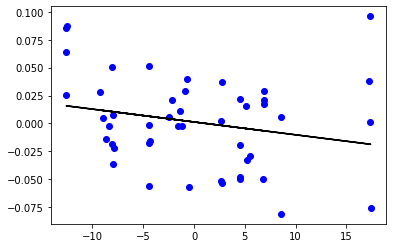

[1.]
context h_theta
-0.3487181441342003 0.034406767816904334 spear -0.3965817689861136 0.015094726494825225


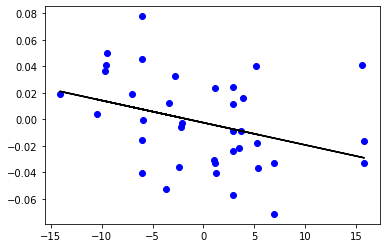

In [31]:
"""
Representations along the Hippocampal Anteroposterior Axis
"""

###############################################################################
st = study('Olfacto')
path_csv = join(st.path, 'feature_new/Ttest_{}_tps/')
csv_file = join(path_csv,'df_wth_btw_diff_freq={}_L.csv')
###############################################################################
conds = ['context']#,'context']#,'mem2','mem3'] #'odor'
freqs = ['l_theta','h_theta']

for cond, freq in product(conds,freqs):
    df = pd.read_csv(csv_file.format(cond,freq))
    df_sel = df.loc[df['labels'].isin(['aHC','HC'])]
    df_sel = df_sel.loc[df_sel['y']<50]
    df_sel['x2'] = [abs(x) for x in df_sel['x']]
    
    #create clusters of electrodes along y dimension
    pca = PCA()
    x_pca = pca.fit_transform(df_sel[['y']])#,'y','z']])
    coords = x_pca[:,0]
    print(pca.explained_variance_ratio_)
    #print(coords,df_sel['x2'].values)
    
    df_mean = df_sel
    R,p = pearsonr(coords,df_mean['tps_diff'])
    R_spear,p_spear = spearmanr(coords,df_mean['tps_diff'])
    print(cond,freq)
    print(R,p,'spear',R_spear,p_spear)
    plt.plot(coords,df_mean['tps_diff'],'bo')
    b, m = polyfit(coords,df_mean['tps_diff'], 1)
    plt.plot(coords, b + m * coords, '-',color='black')
    plt.show()

-> Olfacto loaded
(19, 22)


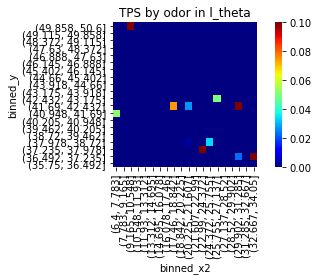

(28, 22)


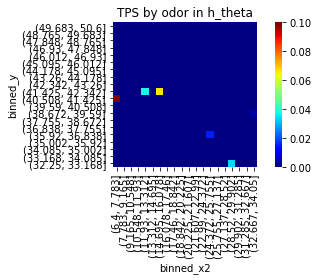

In [25]:
"""
Representations of Odors in OFC
"""

###############################################################################
st = study('Olfacto')
path_csv = join(st.path, 'feature_new/Ttest_{}_tps/')
csv_file = join(path_csv,'df_wth_btw_diff_freq={}_L.csv')
###############################################################################
conds = ['odor']
freqs = ['l_theta','h_theta']
thrs = [0.05]
corrections = ['unc_']

for cond, freq in product(conds,freqs):
    df = pd.read_csv(csv_file.format(cond,freq))
    df_sel = df.loc[df['labels'].isin(['OFC','OFC_olf'])]
    print(df_sel.shape)
    df_sel['x_2'] = [abs(x) for x in df_sel['x']]
    
    #create clusters of electrodes along y dimension
    y_bins = np.histogram_bin_edges(df_sel['y'],bins=20)
    x_bins = np.histogram_bin_edges(df_sel['x_2'],bins=20)
    df_sel['binned_y'] = pd.cut(df_sel['y'], bins=y_bins)
    df_sel['binned_x2'] = pd.cut(df_sel['x_2'], bins=x_bins)
    df_mean = df_sel.groupby(['binned_y','binned_x2'],as_index=False).mean()
    df_mean = df_mean[['binned_y','binned_x2','tps_diff']]
    piv = pd.pivot_table(df_mean, values="tps_diff",index=["binned_y"],
                                 columns=["binned_x2"], fill_value=0, dropna=False)
    
    ax = sns.heatmap(piv, square=True,vmin=0, vmax=0.1, cmap='jet')
    ax.invert_yaxis()
    plt.title('TPS by '+cond+' in '+freq)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90 )
    plt.tight_layout()
    plt.show()

-> Olfacto loaded
(240,) 240 240
odor l_theta ['aHC']
0.2622497773143142 0.14705708689962874 spear 0.16188468849372 0.3760580026278668


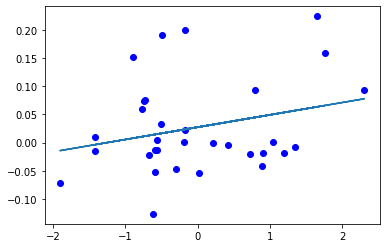

(166,) 166 166
odor h_theta ['aHC']
-0.02063684432033023 0.9021249850964604 spear 0.0043775650384636385 0.9791905206635971


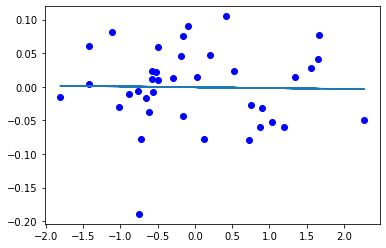

(122,) 122 122
odor l_theta ['HC']
-0.36780164216916544 0.19573117920242075 spear -0.3278329816570155 0.2525179894868294


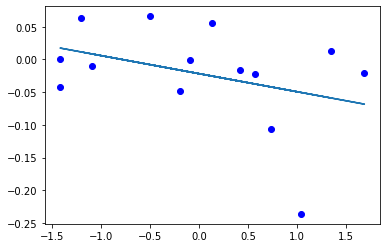

(116,) 116 116
odor h_theta ['HC']
-0.17872012513391103 0.540989163306275 spear -0.198019921806251 0.49738323621605085


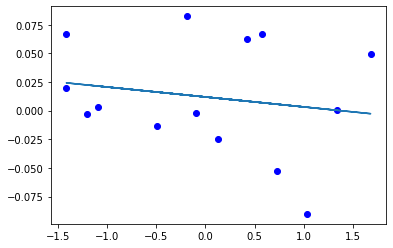

(362,) 362 362
odor l_theta ['aHC', 'HC']
0.15671814191955202 0.34740875096961205 spear 0.038632011464441604 0.8178785989337712


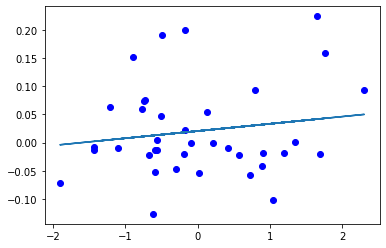

(282,) 282 282
odor h_theta ['aHC', 'HC']
0.017410301441340315 0.9173702335641097 spear 0.021012312184625462 0.9003530573011431


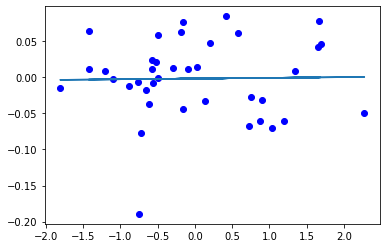

(145,) 145 145
odor l_theta ['OFC', 'OFC_olf']
-0.45223150816683916 0.01786873143783477 spear -0.37795756813422665 0.05192086191402647


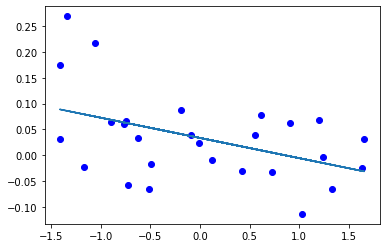

(208,) 208 208
odor h_theta ['OFC', 'OFC_olf']
0.0633842041173717 0.6863621129535024 spear 0.1321502745876278 0.3982527203441495


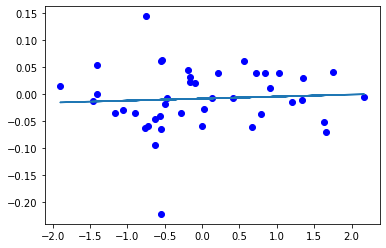

In [30]:
"""
TPS and Memory Richness
"""
###############################################################################
st = study('Olfacto')
path_wth = join(st.path, 'feature_new/TPSim_by_{}_wth/')
path_btw = join(st.path, 'feature_new/TPSim_by_{}_btw/')
tps_file = '{}_odors=all_tps={}_elecs=psd_freq={}.npz'
path_diff = join(st.path, 'feature_new/TPSim_by_{}_diff/')
###############################################################################
conds = ['odor']#,'mem2','mem3'] #'odor'
freqs = ['l_theta','h_theta']
rois =  [['aHC'],['HC'],['aHC','HC'],['OFC','OFC_olf']]#,'OFC_olf']

for roi in rois:
    for cond,freq in product(conds,freqs):
        tps_od_su, score_od, su_list, od_list = [], [], [], []
        for su in subjects:
            mat = np.load(join(path_diff.format(cond),
                           tps_file.format(su,'diff',freq)),allow_pickle=True)
            id_elecs = [i for i,lab in enumerate(mat['labels']) if lab in roi]
            tps_sel = mat['tps'][id_elecs,:]

            if tps_sel.shape[0] > 0:
                for od in np.unique(mat['odor']):
                    tps_od = np.mean(tps_sel[:,np.where(mat['odor']==od)[0]],axis=1)
                    tps_od_pos = tps_od[np.where(tps_od>0)[0]]
                    #tps_od = tps_od_pos
                    if len(tps_od) > 0:
                        tps_od_su.append(tps_od)
                        su_list.extend([su]*tps_od.shape[0])
                        od_list.extend([od]*tps_od.shape[0])
                        score_od.extend([score_odor_su[su][od]]*tps_od.shape[0])
        tps_od_su = np.concatenate(tps_od_su,axis=-1)
        score_od = np.array(score_od)
        su_list = np.array(su_list)
        od_list = np.array(od_list)
        print(tps_od_su.shape,len(score_od),len(su_list))

        #mean by subject tps
        data = np.concatenate((tps_od_su[:,np.newaxis],score_od[:,np.newaxis],
                               su_list[:,np.newaxis], od_list[:,np.newaxis]),axis=1)
        df = pd.DataFrame(data=data, columns=['tps','score','subjects','odors'])
        df['tps'] = df['tps'].astype('float')
        df['score'] = df['score'].astype('float')
        df['score_z'] = (df['score'] - df.groupby(['subjects']).score.transform('mean'))\
                        / df.groupby(['subjects']).score.transform('std')
        df_su = df.groupby(['subjects','odors']).mean()

        R,p = pearsonr(df_su['tps'],df_su['score_z'])
        R_spear,p_spear = spearmanr(df_su['tps'],df_su['score_z'])
        print(cond,freq,roi)
        print(R,p,'spear',R_spear,p_spear)

        plt.plot(df_su['score_z'],df_su['tps'],'bo')
        b, m = polyfit(df_su['score_z'],df_su['tps'], 1)
        plt.plot(df_su['score_z'], b + m * df_su['score_z'], '-')
        plt.show()
    

In [ ]:
a = np.array(['HC','OFC','OFC_olf','aHC','INS'])
roi = ['aHC','HC']
x_id = np.where((a==roi[0])|(a==roi[1]))[0]
x_id